### Clelia Caetano 2023060 (CA2_SEM2)
### MSc. in Data Analytics
### Project Tweets

- The objective of this study is to utilize a large dataset that will be stored in two NoSQL databases. The data will be processed in a Spark environment and Spark SQL language will be used. After eliminating unnecessary data, a comparative performance analysis of the databases will be conducted. 
- Additionally, a sentiment analysis will be performed on the texts extracted from Twitter. Lastly, a time series analysis will be carried out to identify any potential trends or patterns. In addition, projects a forecasts with 1 week, 1 month and 3 months.

In [1]:
sc.master

'local[*]'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the libraries
import os
from pyspark.sql import SparkSession

### Initialize Spark Session

In [4]:
# Create a Spark session with necessary configurations
spark = SparkSession.builder.appName('ProjectTweets') \
                    .config("spark.some_config_option", "config_value") \
                    .getOrCreate()

### Read the Data from HDFS

In [5]:
# Load the data and create a temporary view in Spark
try:
    # Read the data.csv into Hadoop from HDFS (Hadoop Distributed File System) storage
    data = spark.read.option("header", "true").csv("hdfs://localhost:9000/user/hduser/CA2/ProjectTweets.csv")
    
    # Check if the data was loaded successfully
    if data is not None:
        # Define column names
        new_column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

        # Use the alias method to rename the columns
        for i in range(len(new_column_names)):
            data = data.withColumnRenamed(data.columns[i], new_column_names[i])

        # Create a temporary table from the DataFrame
        data.createOrReplaceTempView("CA2_ProjectTweets")

        # Run Spark SQL queries using the same SparkSession
        data = spark.sql("SELECT * FROM CA2_ProjectTweets") 

        # Display the first 5 rows
        data.show(5)
    else:
        print("Data not loaded successfully.")

except Exception as e:
    print("An error occurred:", str(e))

+------+----------+--------------------+--------+-------------+--------------------+
|number|  id_tweet|                date|   query|      user_id|               tweet|
+------+----------+--------------------+--------+-------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|
+------+----------+--------------------+--------+-------------+--------------------+
only showing top 5 rows



### Create a Hive database in Spark application

In [6]:
# Save the DataFrame as a Hive table
data.write.mode("overwrite").saveAsTable("ca2_projecttweets")

2023-11-17 16:02:53,110 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-11-17 16:02:53,112 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-11-17 16:02:57,374 WARN metastore.ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
2023-11-17 16:02:57,375 WARN metastore.ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore hduser@127.0.1.1
2023-11-17 16:02:58,490 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
2023-11-17 16:03:13,485 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2023-11-17 16:03:13,846 WARN conf.HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
2023-11-17 16:0

In [7]:
import time
from pyspark.sql import SparkSession

# Create a Spark session with Hive configurations
spark = SparkSession.builder \
    .appName("HiveAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.hadoop.hive.execution.engine", "tez") \
    .config("spark.hadoop.hive.stats.autogather", "true") \
    .config("spark.hadoop.hive.optimize.ppd", "true") \
    .getOrCreate()

# Start measuring time
start_time = time.time()

In [8]:
# Set the current database
spark.sql("USE ca2_projecttweets")

DataFrame[]

In [9]:
# Run a SQL query to select all rows from the table
result = spark.sql("SELECT `number`, `id_tweet`, `date`, `query`, `user_id`, `tweet` FROM ca2_projecttweets")

# Show the first 5 rows
result.show(5)

+------+----------+--------------------+--------+-------------+--------------------+
|number|  id_tweet|                date|   query|      user_id|               tweet|
+------+----------+--------------------+--------+-------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|
+------+----------+--------------------+--------+-------------+--------------------+
only showing top 5 rows



In [10]:
# Save the preprocessed data as a new table if needed
result.write.mode("overwrite").saveAsTable("preprocessed_ca2_projecttweets")

In [11]:
# Access the Hive table and create a DataFrame
data = spark.table("preprocessed_ca2_projecttweets")

# Print the schema
data.printSchema()

root
 |-- number: string (nullable = true)
 |-- id_tweet: string (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: string (nullable = true)



In [12]:
# Check the size of the data
data_size = data.count()
print(f"The size of the dataset is: {data_size} rows")

The size of the dataset is: 1599999 rows


### Exploratory data analysis (EDA)

In [13]:
# Calculate the number of unique values in each column.
# List of column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

# Dictionary to store unique value counts
unique_counts = {}

# Iterate through the columns and count unique values
for column_name in column_names:
    unique_values = data.select(column_name).distinct()
    unique_count = unique_values.count()
    unique_counts[column_name] = unique_count

# Print the overall count for each column
print("Overall unique value counts:")
for column, count in unique_counts.items():
    print(f"{column}: {count}")

Overall unique value counts:
number: 1599999
id_tweet: 1598314
date: 774362
query: 1
user_id: 659775
tweet: 1581465


In [14]:
# Drop columns that are duplicates and other irrelevant data information
data = data.drop('number', 'id_tweet', 'query', 'user_id')

# Show the updated DataFrame
data.show(5)

+--------------------+--------------------+
|                date|               tweet|
+--------------------+--------------------+
|Mon Apr 06 22:19:...|is upset that he ...|
|Mon Apr 06 22:19:...|@Kenichan I dived...|
|Mon Apr 06 22:19:...|my whole body fee...|
|Mon Apr 06 22:19:...|@nationwideclass ...|
|Mon Apr 06 22:20:...|@Kwesidei not the...|
+--------------------+--------------------+
only showing top 5 rows



### Missing Values

In [15]:
# Iterate through all columns and print missing value counts
for column_name in data.columns:
    missing_count = data.filter(data[column_name].isNull()).count()
    print(f"Missing values in '{column_name}': {missing_count}")

Missing values in 'date': 0
Missing values in 'tweet': 0


In [16]:
# Print the schema
data.printSchema()

root
 |-- date: string (nullable = true)
 |-- tweet: string (nullable = true)



In [17]:
# Call the columns
columns = ["date", "tweet"]

# Set 'tweet' column as the index to convert it as label
data = data.withColumn("label", data["tweet"])

### Descriptive Statistics

In [18]:
# Compute and interpret the mean, median, quartiles, and standard deviation for "date" and "tweet count"
data.describe(["date"]).show()

+-------+--------------------+
|summary|                date|
+-------+--------------------+
|  count|             1599999|
|   mean|                null|
| stddev|                null|
|    min|Fri Apr 17 20:30:...|
|    max|Wed May 27 07:27:...|
+-------+--------------------+



### Create a configuration to convert string 'date' into timestamp

In [19]:
# Config SparkSession from UTC to Pacific Day Time which is the same timezone as the original dataset
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

# Import libraries to convert
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.types import TimestampType

# Convert 'date' column in string format to the timestamp
data = data.withColumn("date", from_unixtime(unix_timestamp(data["date"], "E MMM dd HH:mm:ss z yyyy")).cast(TimestampType()))

# Print the 'date' column with the new format
data.select("date").show(5)

+-------------------+
|               date|
+-------------------+
|2009-04-06 22:19:49|
|2009-04-06 22:19:53|
|2009-04-06 22:19:57|
|2009-04-06 22:19:57|
|2009-04-06 22:20:00|
+-------------------+
only showing top 5 rows



### Groupby 'date'

In [20]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
date_counts = data.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
date_counts = date_counts.orderBy("date_without_hour")

# Collect the data to the driver
date_counts = date_counts.collect()

# Extract dates and tweet counts for plotting
dates = [str(row.date_without_hour) for row in date_counts]
tweet_counts = [row.tweet_count for row in date_counts]

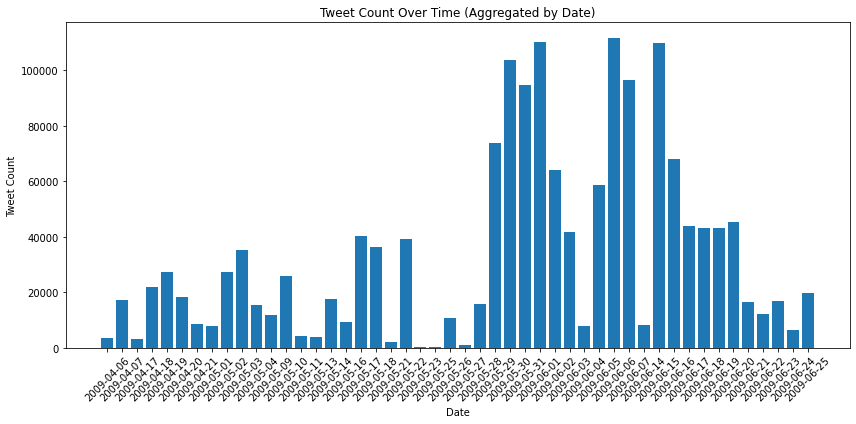

In [21]:
# Plot the tweet count
plt.figure(figsize=(12, 6))
plt.bar(dates, tweet_counts)
plt.title("Tweet Count Over Time (Aggregated by Date)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
from pyspark.sql.functions import col, date_add, datediff
import pyspark.sql.functions as F
from datetime import date, timedelta

# Extract the date part from the 'date' column
data = data.withColumn("date", col("date").cast("date"))

# Sort the DataFrame by date
data = data.orderBy("date")

# Calculate the next date using the lead function
data = data.withColumn("next_date", date_add(col("date"), 1))

# Check if the next date is continuous (no break)
data = data.withColumn("is_continuous", datediff(col("next_date"), col("date")) == 1)

# Create a window specification to order by date
window_spec = Window.orderBy("date")

# Assign a group identifier to continuous sequences
data = data.withColumn("group_id", F.sum(col("is_continuous").cast("int")).over(window_spec))

# Filter only the rows with continuous sequences
continuous_dates = data.filter(col("is_continuous")).select("date").distinct()

# Sort the list in ascending order
continuous_dates = continuous_dates.orderBy("date")

# Get the first and last dates in the DataFrame
first_date = continuous_dates.first().date
last_date = continuous_dates.orderBy(col("date").desc()).first().date

# Print the first and last dates
print("First Date:", first_date)
print("Last Date:", last_date)

# Define the start and end date for the range
start_date = first_date
end_date = last_date

# Generate a list of all dates in the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert the list of continuous dates to a Python list
continuous_dates_list = [row.date for row in continuous_dates.collect()]

# Find the dates not in the list
missing_dates = [d for d in date_range if d not in continuous_dates_list]

# Print the missing dates
for missing_date in missing_dates:
    print(missing_date)

# Count the missing days
missing_days_count = len(missing_dates)

# Print the missing days count
print("Missing Days Count:", missing_days_count)

First Date: 2009-04-06
Last Date: 2009-06-25


2009-04-08
2009-04-09
2009-04-10
2009-04-11
2009-04-12
2009-04-13
2009-04-14
2009-04-15
2009-04-16
2009-04-22
2009-04-23
2009-04-24
2009-04-25
2009-04-26
2009-04-27
2009-04-28
2009-04-29
2009-04-30
2009-05-05
2009-05-06
2009-05-07
2009-05-08
2009-05-12
2009-05-15
2009-05-19
2009-05-20
2009-05-24
2009-06-08
2009-06-09
2009-06-10
2009-06-11
2009-06-12
2009-06-13
Missing Days Count: 33


### Outliers

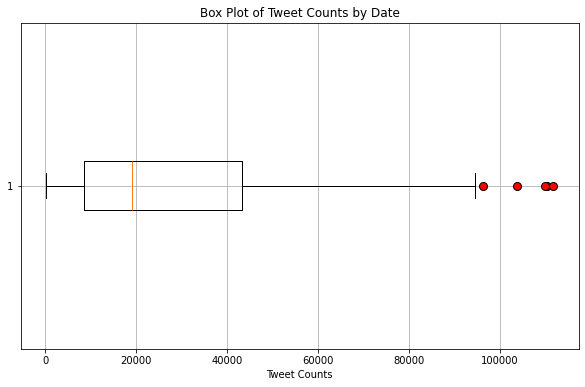

In [23]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
date_counts = data.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
date_counts = date_counts.orderBy("date_without_hour")

# Collect the data to the driver
date_counts = date_counts.collect()

# Extract tweet counts for plotting
tweet_counts = [row.tweet_count for row in date_counts]

# Create a box plot with outliers marked
plt.figure(figsize=(10, 6))
plt.boxplot(tweet_counts, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title("Box Plot of Tweet Counts by Date")
plt.xlabel("Tweet Counts")
plt.grid(True)

plt.show()

In [24]:
# Display the potential outliers (if any) and print them
outliers = []

q1 = date_counts[0].tweet_count
q3 = date_counts[-1].tweet_count
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for idx, tweet_count in enumerate(tweet_counts):
    if tweet_count < lower_bound or tweet_count > upper_bound:
        outliers.append((date_counts[idx].date_without_hour, tweet_count))

# Print the potential outliers
print("Potential Outliers:")
for date, count in outliers:
    print(f"Date: {date}, Tweet Count: {count}")

Potential Outliers:
Date: 2009-05-29, Tweet Count: 73827
Date: 2009-05-30, Tweet Count: 103673
Date: 2009-05-31, Tweet Count: 94588
Date: 2009-06-01, Tweet Count: 110290
Date: 2009-06-02, Tweet Count: 64192
Date: 2009-06-05, Tweet Count: 58757
Date: 2009-06-06, Tweet Count: 111676
Date: 2009-06-07, Tweet Count: 96350
Date: 2009-06-15, Tweet Count: 109781
Date: 2009-06-16, Tweet Count: 67980
Date: 2009-06-20, Tweet Count: 45364


### Initialize Spark Session with Cassandra database

In [25]:
# Create a Spark session with necessary configurations
spark = SparkSession.builder \
    .appName('CassandraIntegration') \
    .config("spark.cassandra.connection.host", "127.0.0.1") \
    .getOrCreate()

### Read the Data from Cassandra

In [26]:
# Load the data.csv file
cassandraDF = spark.read.csv("file:///home/hduser/Desktop/CA2_SEM2/activity_from_cassandra.csv", header=True, inferSchema=True)

# Display the first 5 rows
cassandraDF.show(5)

# Measure execution time
start_time = time.time()

+------+----------+--------------------+--------+---------------+--------------------+
|number|  id_tweet|                date|   query|        user_id|               tweet|
+------+----------+--------------------+--------+---------------+--------------------+
|865612|1677490053|Sat May 02 02:21:...|NO_QUERY|    arthur01022|'@sarjalis I'm go...|
|820293|1553677142|Sat Apr 18 14:54:...|NO_QUERY|       LONGMANX|'@xxandip how man...|
| 14810|1553861618|Sat Apr 18 15:24:...|NO_QUERY|        a_paige|'I wish @Kimone_i...|
|263293|1986487107|Sun May 31 18:54:...|NO_QUERY|       fredbohm|'Awesome, 2-1 to ...|
|937429|1793224306|Thu May 14 01:51:...|NO_QUERY|princesslaurenn|'has eaten some c...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [27]:
# Print the schema
cassandraDF.printSchema()

root
 |-- number: integer (nullable = true)
 |-- id_tweet: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: string (nullable = true)



In [28]:
# Check the size of the data
cassandraDF_size = cassandraDF.count()
print(f"The size of the dataset is: {cassandraDF_size} rows")

The size of the dataset is: 1036130 rows


### Exploratory data analysis (EDA)

In [29]:
# Import the necessary modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("CassandraUniqueValues").getOrCreate()

# List of column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

# Dictionary to store unique value counts
unique_counts = {}

# Iterate through the columns and count unique values
for column_name in column_names:
    unique_values = cassandraDF.select(column_name).distinct()
    unique_count = unique_values.count()
    unique_counts[column_name] = unique_count

# Print the overall count for each column
print("Overall unique value counts:")
for column, count in unique_counts.items():
    print(f"{column}: {count}")

Overall unique value counts:
number: 1036130
id_tweet: 1036130
date: 657323
query: 1
user_id: 506785
tweet: 1036130


In [30]:
# Drop columns that are duplicates and other irrelevant data information
cassandraDF = cassandraDF.drop('number', 'id_tweet', 'query', 'user_id')

# Show the updated DataFrame
cassandraDF.show(5)

+--------------------+--------------------+
|                date|               tweet|
+--------------------+--------------------+
|Sat May 02 02:21:...|'@sarjalis I'm go...|
|Sat Apr 18 14:54:...|'@xxandip how man...|
|Sat Apr 18 15:24:...|'I wish @Kimone_i...|
|Sun May 31 18:54:...|'Awesome, 2-1 to ...|
|Thu May 14 01:51:...|'has eaten some c...|
+--------------------+--------------------+
only showing top 5 rows



### Missing Values

In [31]:
# Iterate through all columns and print missing value counts
for column_name in cassandraDF.columns:
    missing_count = cassandraDF.filter(cassandraDF[column_name].isNull()).count()
    print(f"Missing values in '{column_name}': {missing_count}")

Missing values in 'date': 0


Missing values in 'tweet': 0


In [32]:
# Print the schema
cassandraDF.printSchema()

root
 |-- date: string (nullable = true)
 |-- tweet: string (nullable = true)



In [33]:
# Call the columns
columns = ["date", "tweet"]

# Set 'tweet' column as the index to convert it as label
cassandraDF = cassandraDF.withColumn("label", cassandraDF["tweet"])

### Descriptive Statistics

In [34]:
# Compute and interpret the mean, median, quartiles and standard deviation of the dataset
cassandraDF.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|                date|               tweet|               label|
+-------+--------------------+--------------------+--------------------+
|  count|             1036130|             1036130|             1036130|
|   mean|                null|                null|                null|
| stddev|                null|                null|                null|
|    min|Fri Apr 17 20:30:...|'                ...|'                ...|
|    max|Wed May 27 07:27:...|                test|                test|
+-------+--------------------+--------------------+--------------------+



### Create a configuration to convert string 'date' into timestamp

In [35]:
# Config SparkSession from UTC to Pacific Day Time which is the same timezone as the original dataset
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

# Import libraries to convert
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.types import TimestampType

# Convert 'date' column in string format to the timestamp
cassandraDF = cassandraDF.withColumn("date", from_unixtime(unix_timestamp(cassandraDF["date"], "E MMM dd HH:mm:ss z yyyy")).cast(TimestampType()))

# Print the 'date' column with the new format
cassandraDF.select("date").show(5)

+-------------------+
|               date|
+-------------------+
|2009-05-02 02:21:12|
|2009-04-18 14:54:53|
|2009-04-18 15:24:48|
|2009-05-31 18:54:07|
|2009-05-14 01:51:35|
+-------------------+
only showing top 5 rows



### Groupby 'date'

In [36]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandraDF_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
cassandraDF_counts = cassandraDF_counts.orderBy("date_without_hour")

# Collect the data to the driver
cassandraDF_counts = cassandraDF_counts.collect()

# Extract dates and tweet counts for plotting
dates = [str(row.date_without_hour) for row in cassandraDF_counts]
tweet_counts = [row.tweet_count for row in cassandraDF_counts]

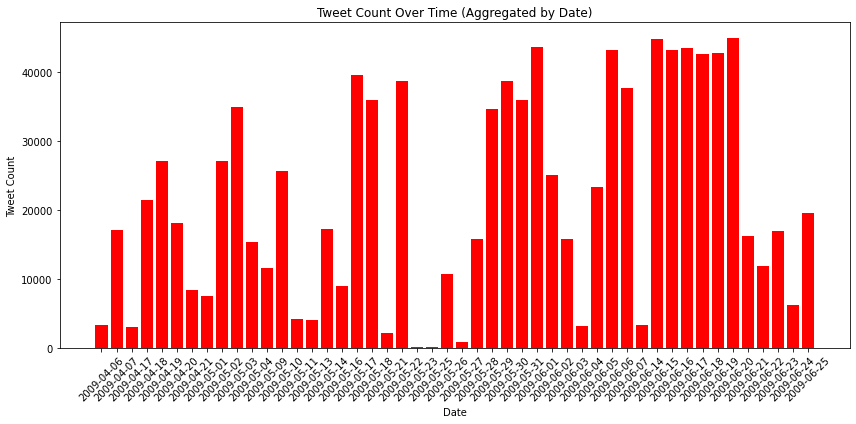

In [37]:
# Plot the tweet count with red bars
plt.figure(figsize=(12, 6))
plt.bar(dates, tweet_counts, color='red')  # Set color to red
plt.title("Tweet Count Over Time (Aggregated by Date)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
from pyspark.sql.functions import col, date_add, datediff
import pyspark.sql.functions as F
from datetime import date, timedelta

# Extract the date part from the 'date' column
cassandraDF = cassandraDF.withColumn("date", col("date").cast("date"))

# Sort the DataFrame by date
cassandraDF = cassandraDF.orderBy("date")

# Calculate the next date using the lead function
cassandraDF = cassandraDF.withColumn("next_date", date_add(col("date"), 1))

# Check if the next date is continuous (no break)
cassandraDF = cassandraDF.withColumn("is_continuous", datediff(col("next_date"), col("date")) == 1)

# Create a window specification to order by date
window_spec = Window.orderBy("date")

# Assign a group identifier to continuous sequences
cassandraDF = cassandraDF.withColumn("group_id", F.sum(col("is_continuous").cast("int")).over(window_spec))

# Filter only the rows with continuous sequences
continuous_dates = cassandraDF.filter(col("is_continuous")).select("date").distinct()

# Sort the list in ascending order
continuous_dates = continuous_dates.orderBy("date")

# Get the first and last dates in the DataFrame
first_date = continuous_dates.first().date
last_date = continuous_dates.orderBy(col("date").desc()).first().date

# Print the first and last dates
print("First Date:", first_date)
print("Last Date:", last_date)

# Define the start and end date for the range
start_date = first_date
end_date = last_date

# Generate a list of all dates in the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert the list of continuous dates to a Python list
continuous_dates_list = [row.date for row in continuous_dates.collect()]

# Find the dates not in the list
missing_dates = [d for d in date_range if d not in continuous_dates_list]

# Print the missing dates
for missing_date in missing_dates:
    print(missing_date)

# Count the missing days
missing_days_count = len(missing_dates)

# Print the missing days count
print("Missing Days Count:", missing_days_count)

First Date: 2009-04-06
Last Date: 2009-06-25


2009-04-08
2009-04-09
2009-04-10
2009-04-11
2009-04-12
2009-04-13
2009-04-14
2009-04-15
2009-04-16
2009-04-22
2009-04-23
2009-04-24
2009-04-25
2009-04-26
2009-04-27
2009-04-28
2009-04-29
2009-04-30
2009-05-05
2009-05-06
2009-05-07
2009-05-08
2009-05-12
2009-05-15
2009-05-19
2009-05-20
2009-05-24
2009-06-08
2009-06-09
2009-06-10
2009-06-11
2009-06-12
2009-06-13
Missing Days Count: 33


### Outliers

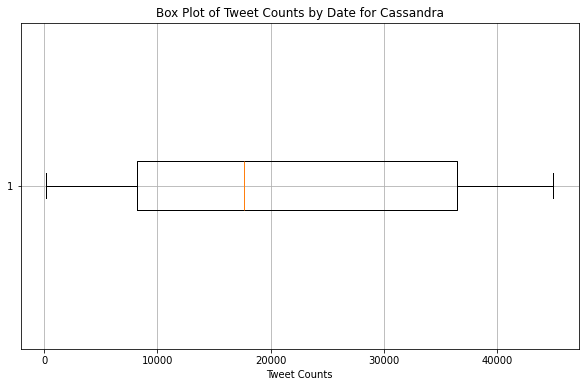

In [39]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count

# Group the data by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandraDF_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
cassandraDF_counts = cassandraDF_counts.orderBy("date_without_hour")

# Collect the data to the driver
cassandraDF_counts = cassandraDF_counts.collect()

# Extract tweet counts for plotting
tweet_counts = [row.tweet_count for row in cassandraDF_counts]

# Create a box plot with outliers marked
plt.figure(figsize=(10, 6))
plt.boxplot(tweet_counts, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title("Box Plot of Tweet Counts by Date for Cassandra")
plt.xlabel("Tweet Counts")
plt.grid(True)

plt.show()

In [40]:
# Display the potential outliers (if any) and print them
outliers = []

q1 = date_counts[0].tweet_count
q3 = date_counts[-1].tweet_count
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for idx, tweet_count in enumerate(tweet_counts):
    if tweet_count < lower_bound or tweet_count > upper_bound:
        outliers.append((date_counts[idx].date_without_hour, tweet_count))

# Print the potential outliers
print("Potential Outliers:")
for date, count in outliers:
    print(f"Date: {date}, Tweet Count: {count}")

Potential Outliers:
Date: 2009-06-15, Tweet Count: 44818
Date: 2009-06-20, Tweet Count: 44946


### Comparison between Hive and Cassandra datasets

In [41]:
# Get the row count for 'data'
hive_row_count = data.count()

# Get the row count for 'cassandraDF'
cassandra_row_count = cassandraDF.count()

# Calculate the total difference
total_difference = hive_row_count - cassandra_row_count

# Print the row counts and total difference
print("Hive Database Row Count:", hive_row_count)
print("Cassandra Database Row Count:", cassandra_row_count)
print("Total Difference:", total_difference)

Hive Database Row Count: 1599999
Cassandra Database Row Count: 1036130
Total Difference: 563869


In [42]:
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the 'data' by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
data_date_counts = data.groupBy("date_without_hour").agg(count("*").alias("data_tweet_count"))

# Group 'cassandraDF' by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandra_date_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("cassandra_tweet_count"))

# Sort the data by date without hour
data_date_counts = data_date_counts.orderBy("date_without_hour")
cassandra_date_counts = cassandra_date_counts.orderBy("date_without_hour")

# Collect the data to the driver
data_date_counts = data_date_counts.collect()
cassandra_date_counts = cassandra_date_counts.collect()

# Extract tweet counts and calculate the total difference per day
data_tweet_counts = [row.data_tweet_count for row in data_date_counts]
cassandra_tweet_counts = [row.cassandra_tweet_count for row in cassandra_date_counts]
difference_per_day = [data - cassandra for data, cassandra in zip(data_tweet_counts, cassandra_tweet_counts)]

# Print the tweet counts for both datasets and the total difference beside
for date, data_count, cassandra_count, diff in zip(data_date_counts, data_tweet_counts, cassandra_tweet_counts, difference_per_day):
    print(f"Date: {date.date_without_hour}, Hive Count: {data_count}, Cassandra Count: {cassandra_count}, Total Difference: {diff}")

Date: 2009-04-06, Hive Count: 3359, Cassandra Count: 3321, Total Difference: 38
Date: 2009-04-07, Hive Count: 17311, Cassandra Count: 17119, Total Difference: 192
Date: 2009-04-17, Hive Count: 3084, Cassandra Count: 3047, Total Difference: 37
Date: 2009-04-18, Hive Count: 21754, Cassandra Count: 21506, Total Difference: 248
Date: 2009-04-19, Hive Count: 27469, Cassandra Count: 27136, Total Difference: 333
Date: 2009-04-20, Hive Count: 18460, Cassandra Count: 18128, Total Difference: 332
Date: 2009-04-21, Hive Count: 8587, Cassandra Count: 8423, Total Difference: 164
Date: 2009-05-01, Hive Count: 7716, Cassandra Count: 7568, Total Difference: 148
Date: 2009-05-02, Hive Count: 27434, Cassandra Count: 27125, Total Difference: 309
Date: 2009-05-03, Hive Count: 35333, Cassandra Count: 34902, Total Difference: 431
Date: 2009-05-04, Hive Count: 15481, Cassandra Count: 15293, Total Difference: 188
Date: 2009-05-09, Hive Count: 11739, Cassandra Count: 11588, Total Difference: 151
Date: 2009-05-

### Normal Distribution Comparison

Shapiro-Wilk Test Results:
Data dataset: p-value = 7.3197452366002835e-06, Not Normally Distributed
CassandraDF dataset: p-value = 0.0011485718423500657, Not Normally Distributed


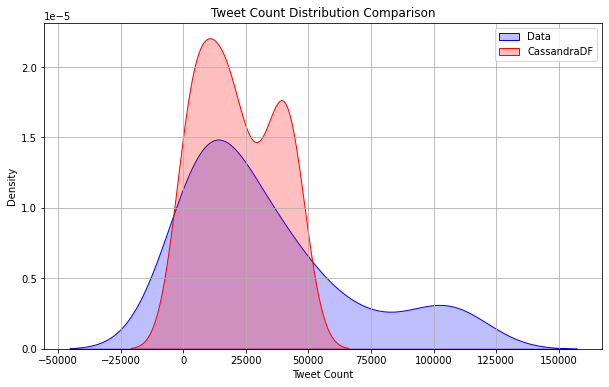

In [43]:
import seaborn as sns
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Extract the tweet counts for both datasets
data_tweet_counts = [row.tweet_count for row in date_counts]
cassandraDF_tweet_counts = [row.tweet_count for row in cassandraDF_counts]

# Create a KDE plot to compare the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data_tweet_counts, label='Data', color='blue', shade=True)
sns.kdeplot(cassandraDF_tweet_counts, label='CassandraDF', color='red', shade=True)
plt.title("Tweet Count Distribution Comparison")
plt.xlabel("Tweet Count")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Perform the Shapiro-Wilk test to check for normal distribution
data_sw_stat, data_sw_p_value = shapiro(data_tweet_counts)
cassandraDF_sw_stat, cassandraDF_sw_p_value = shapiro(cassandraDF_tweet_counts)

# Print the results of the Shapiro-Wilk test
print("Shapiro-Wilk Test Results:")
print(f"Data dataset: p-value = {data_sw_p_value}, {'Normally Distributed' if data_sw_p_value > 0.05 else 'Not Normally Distributed'}")
print(f"CassandraDF dataset: p-value = {cassandraDF_sw_p_value}, {'Normally Distributed' if cassandraDF_sw_p_value > 0.05 else 'Not Normally Distributed'}")

# Show the plot
plt.show()

### Time execution comparison

In [44]:
# Stop measuring time
end_time = time.time()
execution_time = end_time - start_time

print(f"Hive Execution Time: {execution_time} seconds")

Hive Execution Time: 167.56853032112122 seconds


In [45]:
# Stop measuring time
end_time = time.time()
execution_time = end_time - start_time

print(f"Cassandra Execution Time: {execution_time} seconds")

Cassandra Execution Time: 167.60015535354614 seconds


#### Note: A dataset comparison between Hive and Cassandra.

- While these NoSQL datasets were generated from the original data provided as a study tool, a notable difference can be observed in the total number of rows between them:
    - Hive database row count: 1599999
    - Cassandra database row count: 1036130
    - Total Difference: 563869.
- The Hive database was created through HDFS and built using the original file, employing Spark commands in the Jupyter Notebook.
- In contrast, the Cassandra database was created within the Cassandra prompt using commands related to tables, keyspaces and the COPY FROM function, where the original file was used.
- Although the Cassandra dataset did not import the entire original dataset, resulting in a smaller number of rows, its time performance is less efficient than Hive. In other words, Hive performed better every time the commands were restarted and run.

### Modelling 

In [46]:
# Check the DataFrame
data.show(5)

2023-11-17 16:08:44,998 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-17 16:08:45,003 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-17 16:09:27,227 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-17 16:09:34,633 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
|      date|               tweet|               label|date_without_hour| next_date|is_continuous|group_id|
+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
|2009-04-06|is upset that he ...|is upset that he ...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@Kenichan I dived...|@Kenichan I dived...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|my whole body fee...|my whole body fee...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@nationwideclass ...|@nationwideclass ...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@Kwesidei not the...|@Kwesidei not the...|       2009-04-06|2009-04-07|         true|    3359|
+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
only showing top 5 rows



In [47]:
import pandas as pd
from pyspark.sql.functions import concat, lit

# Initialize a Spark session
spark = SparkSession.builder.appName("TweetPreprocessing").getOrCreate()

# Recall the HIVE DataFrame 

# First, create a new column 'tweet' with the same data as 'label'
data = data.withColumn("tweet", data["label"])

# Drop the specified columns
columns_to_drop = ["date_without_hour", "next_date", "is_continuous", "group_id"]
data = data.drop(*columns_to_drop)

# Now, remove the 'label' column and put the text in quotation marks
data = data.drop("label")
data = data.withColumn("tweet", concat(lit('"'), data["tweet"], lit('"')))

# Show the data
data.show(5)

# Save the DataFrame as TweetPreProcessing in Parquet format
data.write.mode("overwrite").save("TweetPreProcessing", format="parquet")

# Convert the Spark DataFrame to a Pandas DataFrame and name it 'df'
df = spark.read.parquet("TweetPreProcessing").toPandas()

# Save the Pandas DataFrame to a CSV file
df.to_csv('processed_data.csv', index=False)

+----------+--------------------+
|      date|               tweet|
+----------+--------------------+
|2009-04-06|"@Kwesidei not th...|
|2009-04-06|"my whole body fe...|
|2009-04-06|"@nationwideclass...|
|2009-04-06|"is upset that he...|
|2009-04-06|"@Kenichan I dive...|
+----------+--------------------+
only showing top 5 rows



### Sentiment Analysis on ProjectTweets

In [48]:
# !pip install pandas langdetect

In [49]:
# Import the necessary libraries
from langdetect import detect

# Initialize a Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Display the first 5 rows of the Pandas DataFrame
df.head(5)

,date,tweet
0,2009-06-02,"""English exam today heh cba with it """
1,2009-06-02,"""is at the doctors lets hope i havent done an..."
2,2009-06-02,"""Still terribly upsetting but actually not as ..."
3,2009-06-02,"""@SdPriceless yea. sus. """
4,2009-06-02,"""@JGDerron Sounds like we are on the same page..."


In [50]:
# Check the shape of the Pandas DataFrame
df.shape

(1599999, 2)

### Convert tweets into sentiments

In [51]:
#!pip install vaderSentiment

In [52]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [53]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Check if the file exists before reading
file_path = '/home/hduser/Desktop/CA2_SEM2/processed_data.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print(f"Error: '{file_path}' not found.")
    # Exit the script or handle the error as needed

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment(text):
    compound_score = analyzer.polarity_scores(text)['compound']
    return compound_score
    
# Apply the function to the 'tweet' column
df['sentiment'] = df['tweet'].apply(get_sentiment)
# Display the first 5 rows of the DataFrame with sentiment
print(df.head(5))

         date                                              tweet  sentiment
0  2009-06-02              "English exam today heh cba with it "    -0.1531
1  2009-06-02  "is at the doctors  lets hope i havent done an...     0.4805
2  2009-06-02  "Still terribly upsetting but actually not as ...     0.5529
3  2009-06-02                          "@SdPriceless yea. sus. "     0.0000
4  2009-06-02  "@JGDerron Sounds like we are on the same page...     0.3612


In [54]:
# Drop the 'tweet' column
df.drop('tweet', axis=1, inplace=True)

# Display the DataFrame with sentiment and without the 'tweet' column
print(df)

               date  sentiment
0        2009-06-02    -0.1531
1        2009-06-02     0.4805
2        2009-06-02     0.5529
3        2009-06-02     0.0000
4        2009-06-02     0.3612
...             ...        ...
1599994  2009-06-25    -0.5106
1599995  2009-06-25     0.0000
1599996  2009-06-25     0.1025
1599997  2009-06-25     0.3612
1599998  2009-06-25     0.1531

[1599999 rows x 2 columns]


### Correlation Matrix

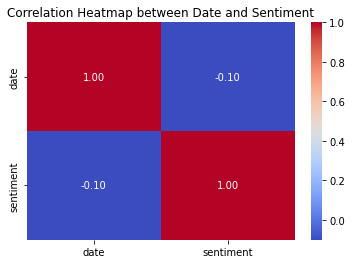

In [55]:
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title to the heatmap
plt.title('Correlation Heatmap between Date and Sentiment')

# Show the plot
plt.show()

Observation:
- As can be seen, there is no correlation between the features ‘date’ and ‘sentiment’.

In [56]:
# Set the 'datetime' column as the index
df.set_index('date', inplace=True)

# Check the data shape
df.shape

(1599999, 1)

In [57]:
df.head(5)

,sentiment
date,
2009-06-02,-0.1531
2009-06-02,0.4805
2009-06-02,0.5529
2009-06-02,0.0000
2009-06-02,0.3612


In [58]:
# Convert the index to DatetimeIndex
df.index = pd.to_datetime(df.index)

# Resample to daily frequency and aggregate sentiments using mean
df_daily = df.resample('D').mean()

# Resetting the index to have 'date' as a column again
df_daily.reset_index(inplace=True)

# Display the resulting DataFrame
print(df_daily)

         date  sentiment
0  2009-04-06   0.150036
1  2009-04-07   0.166612
2  2009-04-08        NaN
3  2009-04-09        NaN
4  2009-04-10        NaN
..        ...        ...
76 2009-06-21  -0.026057
77 2009-06-22  -0.066730
78 2009-06-23  -0.055286
79 2009-06-24  -0.047146
80 2009-06-25  -0.055777

[81 rows x 2 columns]


### Missing Values

In [59]:
# Create series True or False for NaN data and present data respectively. 
nul_df = pd.isnull(df['sentiment']) 
    
# Print only the data, sentiment = NaN 
df[nul_df]

,sentiment
date,


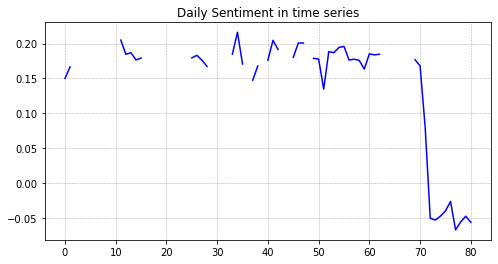

In [60]:
# Set the size of the plot
plt.rcParams['figure.figsize'] = (8, 4)

# Convert index and 'sentiment' column to numpy arrays before plotting
date_values = df_daily.index.to_numpy()
sentiment_values = df_daily['sentiment'].to_numpy()

# Plot the sentiment 
plt.plot(date_values, sentiment_values, color='blue')

# Add title to the time series plot
plt.title('Daily Sentiment in time series')

# Add grid lines
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

In [61]:
#!pip install --upgrade scipy

### Imputing the missing values
- Before applying time series, it is important to check the missing values, so that there is no disruption between the values that will probably impact the results. 
- For this, in this particular study, Linear interpolation was chosen to deal with missing values, in which it calculates the linear relationship of the data range and thus estimates the missing values, fitting these gaps.

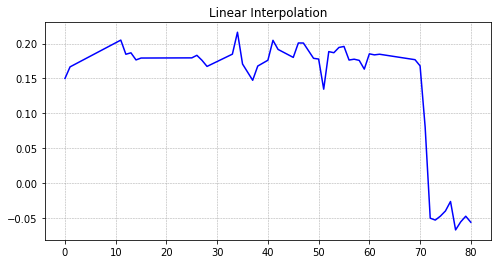

In [62]:
# Linear interpolation
# Set the size of the plot
plt.rcParams['figure.figsize'] = (8, 4)

# Impute the missing values in the "sentiment" column using linear interpolation
df_daily['sentiment'].interpolate(method='linear', inplace=True)

# Plot the complete dataset
plt.plot(df_daily['sentiment'], color='blue')

# Add the title of the plot as Linear Interpolation
plt.title('Linear Interpolation')

# Add grid lines
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

### Outliers

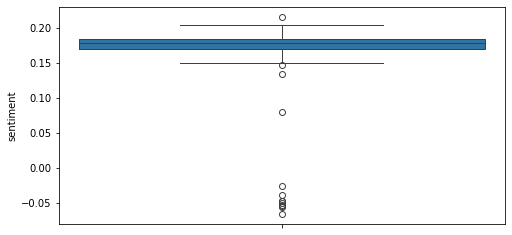

In [63]:
# Create box plots for 'sentiment'
sns.boxplot(df_daily['sentiment'])

# Create a figure 
plt.plot(figsize=(8, 6))

# Show the plot
plt.show()

### Applying Winzorization for Outliers

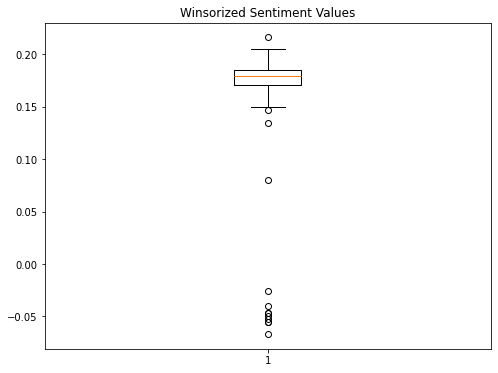

In [64]:
from scipy.stats.mstats import winsorize

# Reduce the impact of extreme outliers (noise) on the data
plt.figure(figsize=(8, 6))

# Replace the bottom 1% of the lowest value and the top 1% of the highest value
winsorized_VALUE = winsorize(df_daily['sentiment'], limits=0.01)
plt.boxplot(winsorized_VALUE)
plt.title('Winsorized Sentiment Values')

# Store the updated values in the dataframe
df_daily['sentiment'] = winsorized_VALUE

In [65]:
df_daily.describe()

,date,sentiment
count,81,81.000000
mean,2009-05-16 00:00:00,0.153722
min,2009-04-06 00:00:00,-0.066730
25%,2009-04-26 00:00:00,0.170682
50%,2009-05-16 00:00:00,0.179289
75%,2009-06-05 00:00:00,0.184681
max,2009-06-25 00:00:00,0.216152
std,NaN,0.073995


### Seasonality

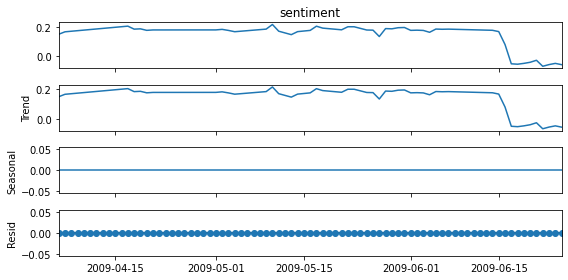

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Call the 'date' column 
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.set_index('date', inplace=True)

# Linear interpolation for missing values
df_daily['sentiment'] = df_daily['sentiment'].interpolate(method='linear')

# Seasonal decomposition
result = seasonal_decompose(df_daily['sentiment'], model='additive', period=1)  # Adjust period based on the expected seasonality

# Plot the decomposition
result.plot()
plt.show()

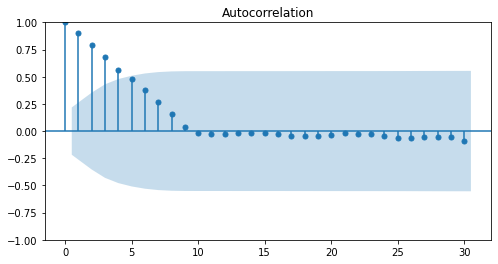

In [67]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation Function (ACF)
plot_acf(df_daily['sentiment'], lags=30)
plt.show()

In [68]:
from statsmodels.tsa.stattools import adfuller

# Statistical Tests
result_adf = adfuller(df_daily['sentiment'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

# Interpret the results
if result_adf[1] <= 0.05:
    print("The time series is stationary (reject the null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis)")

ADF Statistic: -0.3834829330758491
p-value: 0.9128202244524831
The time series is non-stationary (fail to reject the null hypothesis)


### Observation:
- Autocorrelation Function (ACF) plot, indicates a positive values at the beginning that gradually drop below 0 as it move further back in time. it suggests a weakening correlation with past observations. It suggest that there might not be a strong seasonality in the data.
- The p-value associated with the ADF statistic is 0.9128, suggesting that 'fail to reject the null hypothesis of a unit root'. In other words, indicates that the data is non-stationary and the time series may have a unit root or exhibit a trend.

ADF Statistic: -7.227043546632276
p-value: 2.0402194026983683e-10
The time series is stationary (reject the null hypothesis)


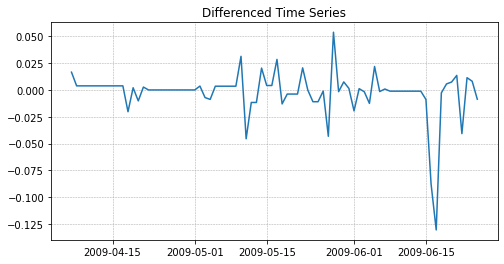

In [69]:
# Perform differenced directly on the "sentiment" column
df_daily['sentiment'] = df_daily['sentiment'].diff().dropna()

# Check for stationarity using ADF test on the differenced data
result_adf = adfuller(df_daily['sentiment'].dropna())
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

# Interpret the results
if result_adf[1] <= 0.05:
    print("The time series is stationary (reject the null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis)")

# Visualize the differenced time series
plt.plot(df_daily['sentiment'])
plt.title("Differenced Time Series")
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)
plt.show()

### Normal Distribution

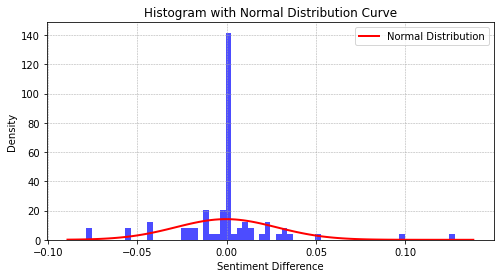

In [70]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Perform differencing directly on the "sentiment" column
df_daily['sentiment'] = df_daily['sentiment'].diff().dropna()

# Plot histogram of the differenced time series
plt.hist(df_daily['sentiment'].dropna(), bins='auto', color='blue', alpha=0.7, density=True)

# Fit a normal distribution to the data
mu, std = df_daily['sentiment'].mean(), df_daily['sentiment'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Plot the normal distribution curve in red
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

plt.title("Histogram with Normal Distribution Curve")
plt.xlabel("Sentiment Difference")
plt.ylabel("Density")
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [71]:
# Print the first and last date
first_date = df_daily.index[0]
last_date = df_daily.index[-1]

print("First Date:", first_date)
print("Last Date:", last_date)

# Print the total count of dates
total_dates = len(df_daily)
print("Total Dates:", total_dates)

First Date: 2009-04-06 00:00:00
Last Date: 2009-06-25 00:00:00
Total Dates: 81


### Splitting the dataset into test and train

In [72]:
# Calculate the percentage split
percentage_train = 0.7
total_days = len(df_daily)
split_index = int(percentage_train * total_days)

# Extract the split date
split_date = df_daily.index[split_index]

# Create training and testing sets
train = df_daily[df_daily.index < split_date]
test = df_daily[df_daily.index >= split_date]

# Print the count of values in the training and testing sets
print(f"Count of values in training set: {len(train)}")
print(f"Count of values in testing set: {len(test)}")

# Print the testing set
print(test)

Count of values in training set: 56
Count of values in testing set: 25
               sentiment
date                    
2009-06-01 -2.097260e-02
2009-06-02  2.070569e-02
2009-06-03 -2.901288e-03
2009-06-04 -1.083862e-02
2009-06-05  3.440027e-02
2009-06-06 -2.336571e-02
2009-06-07  2.397025e-03
2009-06-08 -2.026733e-03
2009-06-09  2.775558e-17
2009-06-10 -2.775558e-17
2009-06-11  2.775558e-17
2009-06-12 -2.775558e-17
2009-06-13  2.775558e-17
2009-06-14 -2.775558e-17
2009-06-15 -7.743943e-03
2009-06-16 -7.871804e-02
2009-06-17 -4.278670e-02
2009-06-18  1.276488e-01
2009-06-19  8.319162e-03
2009-06-20  1.812048e-03
2009-06-21  6.151536e-03
2009-06-22 -5.424046e-02
2009-06-23  5.211725e-02
2009-06-24 -3.303951e-03
2009-06-25 -1.677116e-02


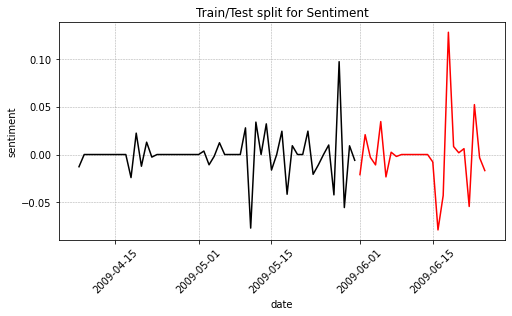

In [73]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('sentiment')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sentiment")
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)
plt.show()

### Model 1: Autoregressive Integrated Moving Average (ARIMA) 

In [74]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# Split the data into training and testing sets
train_size = int(len(df_daily) * 0.7)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

# Determine the range for p, d, q 
p = d = q = range(0, 3)  # Example: Considering values up to 3 for simplicity

# Use the Grid Search Hyperparameter
# Generate all possible combinations of p, d, q parameters 
pdq = list(itertools.product(p, d, q))

# Fit ARIMA models and select the one with the lowest AIC
best_aic = float('inf')
best_order = None

for order in pdq:
    try:
        model = ARIMA(train['sentiment'], order=order, freq='D')  # Specify frequency
        fit_model = model.fit()
        current_aic = fit_model.aic
        if current_aic < best_aic:
            best_aic = current_aic
            best_order = order
    except:
        continue

print(f'Best Order (p, d, q): {best_order} with AIC: {best_aic}')

Best Order (p, d, q): (1, 0, 1) with AIC: -295.91479979933854


Root Mean Squared Error (RMSE): 0.03696263651409014


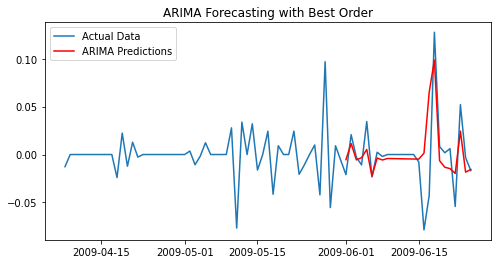

In [75]:
# Use the best_order to fit your final ARIMA model
final_model = ARIMA(df_daily['sentiment'], order=best_order)
final_fit_model = final_model.fit()

# Forecast
predictions = fit_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Evaluate the model
rmse = sqrt(mean_squared_error(test['sentiment'], predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Apply the ARIMA model to the test set
predictions = final_fit_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Plot the predictions
predictions = final_fit_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
plt.plot(df_daily.index, df_daily['sentiment'], label='Actual Data')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Forecasting with Best Order')
plt.legend()
plt.show()

### Model 2: LSTM (Long Short-Term Memory) 

### Training and Testing Data

In [76]:
# Training Data
# Selecting sentiment
dataset_train = train['sentiment']  # Use 'train' instead of 'train_data'

# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train.values, (-1, 1))  # Convert to values and then reshape
print(dataset_train.shape)

# Testing Data
# Selecting sentiment
dataset_test = test['sentiment']  # Use 'test' instead of 'test_data'

# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test.values, (-1, 1))  # Convert to values and then reshape
print(dataset_test.shape)

(56, 1)
(25, 1)


### Normalization

In [77]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Handle missing values (replace NaN with a specific value or impute)
train = np.nan_to_num(train)
test = np.nan_to_num(test)

# Create a scaler and fit it on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
print(scaled_train[:5])

# Use the same scaler to transform the test data
scaled_test = scaler.transform(test)
print(scaled_test[:5])

[[0.44214245]
 [0.44214245]
 [0.3687859 ]
 [0.44214245]
 [0.44214245]]
[[0.32143052]
 [0.56131812]
 [0.42544351]
 [0.37975865]
 [0.64013995]]


### Transforming the data into Sequence

In [78]:
import torch

# Create sequences and labels for training data
sequence_length_train = 50
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length_train):
    X_train.append(scaled_train[i:i + sequence_length_train])
    y_train.append(scaled_train[i + sequence_length_train:i + sequence_length_train + 1])

X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Create sequences and labels for testing data
sequence_length_test = 10
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length_test):
    X_test.append(scaled_test[i:i + sequence_length_test])
    y_test.append(scaled_test[i + sequence_length_test:i + sequence_length_test + 1])

X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


X_train.shape,y_train.shape
X_test.shape, y_test.shape

(torch.Size([15, 10, 1]), torch.Size([15, 1, 1]))

### Define LSTM class model

In [79]:
import torch.nn as nn

class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

### Check Hardware Availability

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Defining the model

In [81]:
input_size = 1
num_layers = 2
hidden_size = 10
output_size = 1
 
# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

# Define the optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adjust the learning rate as needed

print(model)

LSTMModel(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


### Creating Data Loader for batch training

In [82]:
from torch.utils.data import DataLoader

batch_size = 15
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model Training & Evaluations

In [83]:
# Training loop
num_epochs = 50
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average training loss
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
        num_batches = len(test_loader)

        if num_batches > 0:
            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)

                total_test_loss += test_loss.item()

            # Calculate average test loss
            average_test_loss = total_test_loss / num_batches
            test_hist.append(average_test_loss)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
        else:
            print(f'Warning: Empty test loader at epoch {epoch + 1}')

Epoch [10/50] - Training Loss: 0.3521, Test Loss: 0.3158
Epoch [20/50] - Training Loss: 0.2752, Test Loss: 0.2544
Epoch [30/50] - Training Loss: 0.2026, Test Loss: 0.1976
Epoch [40/50] - Training Loss: 0.1350, Test Loss: 0.1460
Epoch [50/50] - Training Loss: 0.0916, Test Loss: 0.1095


In [84]:
# Calculate predictions on the test set
model.eval()
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        predictions_test = model(batch_X_test)

        # Assuming predictions have shape [batch_size, sequence_length, 1]
        predictions_test = predictions_test[:, -1, :]  # Extract the last time step
        predictions_test = predictions_test.view(-1)  # Flatten to 1D

        y_true_test.extend(batch_y_test.cpu().numpy().ravel())
        y_pred_test.extend(predictions_test.cpu().numpy().ravel())

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

# Ensure the lengths of y_true_test and y_pred_test match
if len(y_true_test) != len(y_pred_test):
    raise ValueError("Inconsistent number of samples between y_true_test and y_pred_test")

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true_test, y_pred_test)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.2661591172218323


### Plotting the Learning Curve

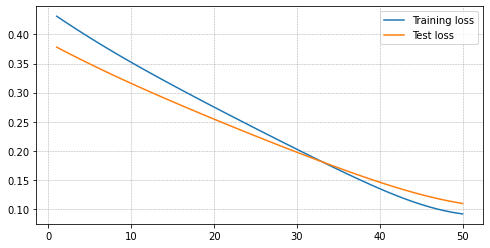

In [85]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)
plt.show()

### Forecasting

In [86]:
# Convert it to a Pandas DataFrame with an appropriate index
test_df = pd.DataFrame(data=test, index=pd.date_range(start='2009-04-06', periods=len(test)))

# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value)

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Get the last date from the DataFrame index
last_date = test_df.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)

# Concatenate the original index with the future dates
combined_index = test_df.index.append(future_dates)

(10,)


### Prediction Graph

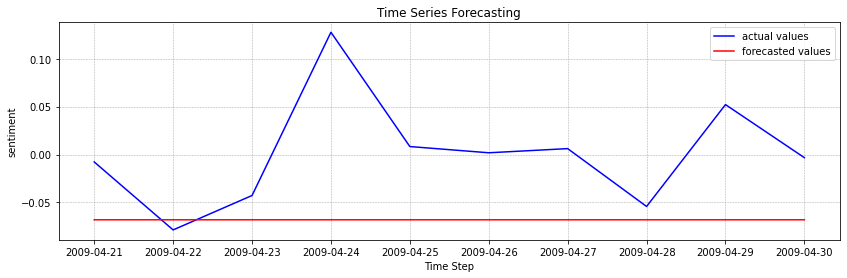

In [87]:
# Set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 

# Reverse the scaling transformation for actual values
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

# The historical data used as input for forecasting
plt.plot(test_df.index[-10:], original_cases[-10:], label='actual values', color='blue')

# Forecasted Values
# Manually scale back the forecasted values to their original range
data_max = scaler.data_max_[0]
data_min = scaler.data_min_[0]
forecasted_cases = np.array(forecasted_values[-10:]) * (data_max - data_min) + data_min

# Create a common time index for both actual and forecasted values
common_index = test_df.index[-10:]

# Plotting the forecasted values
forecasted_cases = forecasted_cases.flatten()  # Ensure it's a 1D array
plt.plot(common_index, forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('sentiment')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)

### Cross-Validation

In [88]:
# !pip install tabulate

In [89]:
from tabulate import tabulate

# Make predictions on your test data
arima_predictions = final_fit_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
lstm_predictions = model(X_test).detach().cpu().numpy().flatten()

# Ensure that arima_predictions and lstm_predictions have the same length
min_length = min(len(arima_predictions), len(lstm_predictions))
arima_predictions = arima_predictions[:min_length]
lstm_predictions = lstm_predictions[:min_length]

# Create a DataFrame for initial predictions
predictions_df = pd.DataFrame({
    'Date': test_df.index[:min_length],
    'ARIMA Predictions': arima_predictions,
    'LSTM Predictions': lstm_predictions
})

# Generate the next 30 dates
future_dates = pd.date_range(start=test_df.index[-1] + pd.DateOffset(1), periods=num_forecast_steps)

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'ARIMA Predictions': [np.nan] * num_forecast_steps,  # Placeholder for ARIMA predictions (you can replace with actual values)
    'LSTM Predictions': forecasted_values[-num_forecast_steps:]  # Use the last 30 LSTM predictions
})

# Concatenate the original predictions_df with the future_predictions_df
combined_predictions_df = pd.concat([predictions_df, future_predictions_df], ignore_index=True)

# Print the combined DataFrame using tabulate
print(tabulate(combined_predictions_df, headers='keys', tablefmt='pretty', showindex=False))

+---------------------+------------------------+----------------------+
|        Date         |   ARIMA Predictions    |   LSTM Predictions   |
+---------------------+------------------------+----------------------+
| 2009-04-06 00:00:00 | -0.005358239910518859  | 0.052272945642471313 |
| 2009-04-07 00:00:00 |  0.011490567560283398  |  0.1204991266131401  |
| 2009-04-08 00:00:00 | -0.005599777164522292  | 0.18369324505329132  |
| 2009-04-09 00:00:00 | -0.0033332255445573593 |  0.2368440330028534  |
| 2009-04-10 00:00:00 | 0.0053074964045331935  |  0.2829662263393402  |
| 2009-04-11 00:00:00 | -0.022757009769417663  |  0.3151630461215973  |
| 2009-04-12 00:00:00 | -0.003667347901855806  | 0.34139183163642883  |
| 2009-04-13 00:00:00 | -0.0057198891953244265 |  0.361047625541687   |
| 2009-04-14 00:00:00 | -0.004162620944128838  |  0.3761588931083679  |
| 2009-04-15 00:00:00 | -0.004270631230179077  |  0.3876853585243225  |
| 2009-04-16 00:00:00 | -0.004377975799231808  | 0.0544359683990

In [90]:
from sklearn.metrics import mean_absolute_error

# Impute NaN values with mean
df_daily['sentiment'].fillna(df_daily['sentiment'].mean(), inplace=True)

# Make predictions on test data using LSTM & ARIMA
lstm_predictions = model(X_test).detach().cpu().numpy().flatten()[:len(test)]
arima_predictions = final_fit_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')[:len(test)]

# Calculate metrics for ARIMA
arima_mae = mean_absolute_error(df_daily['sentiment'][:len(test)], arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(df_daily['sentiment'][:len(test)], arima_predictions))
arima_mse = mean_squared_error(df_daily['sentiment'][:len(test)], arima_predictions)

# Calculate metrics for LSTM
lstm_mae = mean_absolute_error(df_daily['sentiment'][:len(test)], lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(df_daily['sentiment'][:len(test)], lstm_predictions))
lstm_mse = mean_squared_error(df_daily['sentiment'][:len(test)], lstm_predictions)

# Display the metrics
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'MAE': [arima_mae, lstm_mae],
    'RMSE': [arima_rmse, lstm_rmse],
    'MSE': [arima_mse, lstm_mse]
})

print(metrics_df)

   Model       MAE      RMSE       MSE
0  ARIMA  0.017058  0.027206  0.000740
1   LSTM  0.248694  0.271684  0.073812


### Observation:
- ARIMA had the best performance, as it presented the lowest error rates in the metrics shown.
- It is important to highlight that the dataset is not large enough to use the LSTM model, but it was still chosen to apply different techniques and compare the performances and techniques as it was done.

### Dashboard Forecast using the ARIMA Fit Model

In [91]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
final_model = ARIMA(df_daily['sentiment'], order=best_order)
final_fit_model = final_model.fit()

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div(style={'backgroundColor': '#D3D3D3', 'color': '#000000'}, children=[
    html.H1(children='Sentiment Predictions Dashboard', style={'textAlign': 'center', 'color': '#FFFFFF'}),

    # Actual Data Plot
    dcc.Graph(
        id='actual-data',
        figure=px.line(df_daily, x=df_daily.index, y='sentiment', labels={'y': 'Sentiment'}, title='Actual Data')
    ),

    # Time Slider for selecting forecast period
    dcc.Slider(
        id='forecast-period-slider',
        min=7,
        max=90,
        step=7,
        value=7,
        marks={i: f'{i} Days' for i in range(7, 91, 7)},
    ),

    # Forecast Plot
    dcc.Graph(id='forecast-plot'),

    # Link for users to access
    dcc.Link(href="http://your-dashboard-link", children="Access Dashboard"),

])

# Callback to update the forecast plot based on the selected period
@app.callback(
    Output('forecast-plot', 'figure'),
    [Input('forecast-period-slider', 'value')]
)
def update_forecast_plot(selected_period):
    # Get forecast for the selected period
    forecast = final_fit_model.get_forecast(steps=selected_period).predicted_mean

    # Create the forecast plot
    forecast_fig = px.line(df_daily, x=df_daily.index, y='sentiment', labels={'y': 'Sentiment'},
                           title=f'{selected_period} Days Forecast', line_shape='linear')

    # Add the red-colored forecast line
    forecast_fig.add_scatter(x=forecast.index, y=forecast, mode='lines', name='Forecast',
                            line=dict(color='red'))

    return forecast_fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

In [92]:
# Stop the Spark session when "SentimentAnalysis" is done
spark.stop()

### References:

• https://github.com/apache/hive

• https://cassandra.apache.org/doc/latest/cassandra/cql/ddl.html

• Cassandra: The Definitive Guide, (Revised) Third Edition, 3rd Edition, Jeff Carpenter, Eben Hewitt,
O'Reilly Media, Inc., January 2022.

• Pytorch codes adapted from:

   1-  https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/
   
   2-  https://www.datacamp.com/tutorial/nlp-with-pytorch-a-comprehensive-guide